Our code for training an LTR with bert for ranking weak premises.

In [5]:
import sys
import os
import torch
import nltk
import numpy as np
import pandas as pd
import json
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [10]:
sys.path.append('../../lib/')
os.environ['CUDA_VISIBLE_DEVICES']= '6'
pd.set_option('display.max_colwidth', None)

In [13]:
import evaluation

In [168]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
#Replace data_path with the folder that contains the Jo et al data
data_path = '/workspace/ceph_data/argument-undermining'

In [27]:
def group_df(df):
    df = df.groupby('title').agg({
        'title' : lambda x: list(x)[0],
        'full_post': lambda x: list(x)[0],
        'premise_counter_premise_pair': lambda x : [attack for comment in list(x) for attack in comment],
    }).reset_index(drop=True)
    
    return df

def convert_jo_to_json(df):
    ranking_problems = []
    for idx, row in df.iterrows():
            documents = []
            attacked_idx = row['qouted_sent_idx']
            for sent_idx, sent in enumerate(row['post']):
                documents.append({"relevance": attacked_idx[sent_idx], 
                 "docText": sent})
            
            ranking_problems.append({
                "queryText": row['title'],
                "documents": documents
            })
    
    return {
        "rankingProblems": ranking_problems
    }

def trim_documents(problem, max_sents=15):
    '''
    Take top 15 sentences, making sure that the relevant sentences are kept and then shuffle.
    '''
    sorted_by_rel = sorted(problem['documents'], key=lambda x: -x['relevance'])
    sorted_by_rel = sorted_by_rel[0:max_sents]
    np.random.shuffle(sorted_by_rel)
    problem['documents'] =  sorted_by_rel
    
    return problem

### Preparing Jo et. al. Data:

In [31]:
jo_df = pd.read_pickle(data_path + '/jo_data/vul_data.pickle')

In [32]:
jo_training_json = convert_jo_to_json (jo_df[jo_df.split=='train'])
jo_valid_json    = convert_jo_to_json(jo_df[jo_df.split=='val'])
jo_testing_json  = convert_jo_to_json(jo_df[jo_df.split=='test'])

In [33]:
print(len(jo_training_json['rankingProblems']))
print(len(jo_valid_json['rankingProblems']))
print(len(jo_testing_json['rankingProblems']))

25839
8763
8558


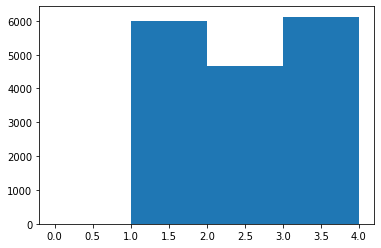

In [172]:
relevants_dist = [sum([doc['relevance'] for doc in p['documents']]) for p in jo_training_json['rankingProblems']]
plt.hist(relevants_dist, bins=[0,1,2,3,4])
plt.show()

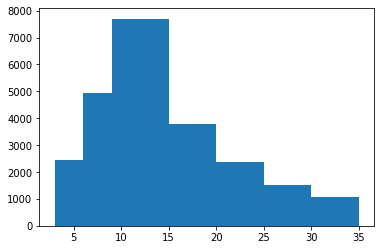

In [173]:
num_sents_dist = [len(p['documents']) for p in jo_training_json['rankingProblems']]
plt.hist(num_sents_dist, bins=[3,6,9,15,20, 25, 30, 35])
plt.show()

In [176]:
json.dump(jo_training_json, open(data_path+'/data/vul_detection/jo_training.json', 'w'))
json.dump(jo_valid_json, open(data_path+'/data/vul_detection/jo_valid.json', 'w'))
json.dump(jo_testing_json, open(data_path+'/data/vul_detection/jo_testing.json', 'w'))

### Training LTR-BERT:

#### Encoding Data:

In [21]:
RANKING_CODE="/workspace/computationally-undermining-arguments/thirdparty"
VOCAN_PATH  = "/workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-12_H-768_A-12_TF2/vocab.txt"
DATA_PATH   ="/workspace/ceph_data/argument-undermining/data/vul_detection"

!python ${RANKING_CODE_PATH}/ranking/tensorflow_ranking/extension/examples/tfrbert_convert_json_to_elwc.py \
    --vocab_file= ${VOCAB_PATH} \
    --sequence_length=128 \
    --input_file=${DATA_PATH}/vul_detection/jo_train.json \
    --output_file=${DATA_PATH}/vul_detection/jo_train.elwc.tfrecord \
    --do_lower_case 

2020-10-29 12:26:55.136957: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Utility to convert between JSON and ELWC for TFR-Bert

Model Parameters: 
Vocabulary filename: /workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-12_H-768_A-12_TF2/vocab.txt
sequence_length: 128
do_lower_case: True


Input file:  /workspace/ceph_data/argument-undermining/data/vul_detection/training.json
Output file: /workspace/ceph_data/argument-undermining/data/vul_detection/training.elwc.tfrecord
Success.


In [22]:
RANKING_CODE="/workspace/computationally-undermining-arguments/thirdparty"
VOCAN_PATH  = "/workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-12_H-768_A-12_TF2/vocab.txt"
DATA_PATH   ="/workspace/ceph_data/argument-undermining/data/vul_detection"

!python ${RANKING_CODE_PATH}/ranking/tensorflow_ranking/extension/examples/tfrbert_convert_json_to_elwc.py \
    --vocab_file= ${VOCAB_PATH} \
    --sequence_length=128 \
    --input_file=${DATA_PATH}/vul_detection/jo_valid.json \
    --output_file=${DATA_PATH}/vul_detection/jo_valid.elwc.tfrecord \
    --do_lower_case 

2020-10-29 12:29:03.432798: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Utility to convert between JSON and ELWC for TFR-Bert

Model Parameters: 
Vocabulary filename: /workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-12_H-768_A-12_TF2//vocab.txt
sequence_length: 128
do_lower_case: True


Input file:  /workspace/ceph_data/argument-undermining/data/vul_detection/valid.json
Output file: /workspace/ceph_data/argument-undermining/data/vul_detection/valid.elwc.tfrecord
Success.


#### Building the Library:

In [ ]:
! bazel build -c opt bazel build -c opt tensorflow_ranking/extension/examples:tfrbert_example_py_binary

#### Training LTR-BERT:

The following are commands to train an LTR-BERT model on the data:

In [38]:
BERT_DIR="/workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-12_H-768_A-12_TF2" #big-bert
DATA_DIR="/workspace/ceph_data/argument-undermining/data/vul_detection"
BAZIL_BIN="/workspace/computationally-undermining-arguments/thirdparty/ranking/bazel-bin/" #path to the built library

In [ ]:
OUTPUT_DIR="/workspace/ceph_data/argument-undermining/models/jo_vul_detection_listwise/"

CUDA_VISIBLE_DEVICES=7 ${BAZIL_BIN}/tensorflow_ranking/extension/examples/tfrbert_example_py_binary \
   --train_input_pattern=${DATA_DIR}/jo_training.elwc.tfrecord \
   --eval_input_pattern=${DATA_DIR}/jo_valid.elwc.tfrecord \
   --bert_config_file=${BERT_DIR}/bert_config.json \
   --bert_init_ckpt=${BERT_DIR}/bert_model.ckpt \
   --bert_max_seq_length=128 \
   --model_dir="${OUTPUT_DIR}" \
   --loss=softmax_loss \
   --train_batch_size=1 \
   --convert_labels_to_binary \
   --eval_batch_size=1 \
   --listwise_inference True \
   --list_size=25 \
   --learning_rate=1e-6 \
   --num_train_steps=30000 \
   --num_eval_steps=200 \
   --checkpoint_secs=200 \
   --bert_num_warmup_steps 1000 \
   --num_checkpoints=5

In [ ]:
OUTPUT_DIR="/workspace/ceph_data/argument-undermining/models/jo_vul_detection_pairwise/"

CUDA_VISIBLE_DEVICES=6 ${BAZIL_BIN}/tensorflow_ranking/extension/examples/tfrbert_example_py_binary \
   --train_input_pattern=${DATA_DIR}/jo_training.elwc.tfrecord \
   --eval_input_pattern=${DATA_DIR}/jo_valid.elwc.tfrecord \
   --bert_config_file=${BERT_DIR}/bert_config.json \
   --bert_init_ckpt=${BERT_DIR}/bert_model.ckpt \
   --bert_max_seq_length=128 \
   --model_dir="${OUTPUT_DIR}" \
   --loss=pairwise_logistic_loss \
   --train_batch_size=1 \
   --convert_labels_to_binary \
   --eval_batch_size=1 \
   --listwise_inference True \
   --list_size=25 \
   --learning_rate=1e-6 \
   --num_train_steps=30000 \
   --num_eval_steps=200 \
   --checkpoint_secs=200 \
   --bert_num_warmup_steps 1000 \
   --num_checkpoints=5

In [ ]:
OUTPUT_DIR="/workspace/ceph_data/argument-undermining/models/jo_vul_detection_pointwise/"

CUDA_VISIBLE_DEVICES=5 ${BAZIL_BIN}/tensorflow_ranking/extension/examples/tfrbert_example_py_binary \
   --train_input_pattern=${DATA_DIR}/jo_training.elwc.tfrecord \
   --eval_input_pattern=${DATA_DIR}/jo_valid.elwc.tfrecord \
   --bert_config_file=${BERT_DIR}/bert_config.json \
   --bert_init_ckpt=${BERT_DIR}/bert_model.ckpt \
   --bert_max_seq_length=128 \
   --model_dir="${OUTPUT_DIR}" \
   --loss=sigmoid_cross_entropy_loss \
   --train_batch_size=1 \
   --convert_labels_to_binary \
   --eval_batch_size=1 \
   --listwise_inference True \
   --list_size=25 \
   --learning_rate=1e-6 \
   --num_train_steps=30000 \
   --num_eval_steps=200 \
   --checkpoint_secs=200 \
   --bert_num_warmup_steps 1000 \
   --num_checkpoints=5

#### Generate Predictions:

Commands to setup the tensorflow predictions server for each of the model, and perform prediction:

In [ ]:
export MODEL_DIR=/workspace/ceph_data/argument-undermining/models/jo_vul_detection_listwise/export/best_model_by_loss/
CUDA_VISIBLE_DEVICES=2 tensorflow_model_server \
  --port=8503 \
  --rest_api_port=8501 \
  --model_name=tfrbert \
  --model_base_path="${MODEL_DIR}"

#!/bin/bash
BERT_DIR="/workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-12_H-768_A-12_TF2"
DATA_DIR="/workspace/ceph_data/argument-undermining/data/vul_detection"
python tensorflow_ranking/extension/examples/tfrbert_client_predict_from_json.py \
    --vocab_file=${BERT_DIR}/vocab.txt \
    --server_port 8503 \
    --sequence_length=128 \
    --input_file=${DATA_DIR}/jo_testing.json \
    --output_file=${DATA_DIR}/listwise-pred-jo-test-tmp.json \
    --do_lower_case

In [ ]:
export MODEL_DIR=/workspace/ceph_data/argument-undermining/models/jo_vul_detection_pointwise/export/best_model_by_loss/
CUDA_VISIBLE_DEVICES=2 tensorflow_model_server \
  --port=8503 \
  --rest_api_port=8506 \
  --model_name=tfrbert \
  --model_base_path="${MODEL_DIR}"

#!/bin/bash
BERT_DIR="/workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-12_H-768_A-12_TF2"
DATA_DIR="/workspace/ceph_data/argument-undermining/data/vul_detection"
python tensorflow_ranking/extension/examples/tfrbert_client_predict_from_json.py \
    --vocab_file=${BERT_DIR}/vocab.txt \
    --server_port 8503 \
    --sequence_length=128 \
    --input_file=${DATA_DIR}/jo_testing.json \
    --output_file=${DATA_DIR}/pointwise-pred-jo-test.json \
    --do_lower_case

In [ ]:
export MODEL_DIR=/workspace/ceph_data/argument-undermining/models/jo_vul_detection_pairwise/export/best_model_by_loss/
CUDA_VISIBLE_DEVICES=2 tensorflow_model_server \
  --port=8507 \
  --rest_api_port=8508 \
  --model_name=tfrbert \
  --model_base_path="${MODEL_DIR}"

#!/bin/bash
BERT_DIR="/workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-12_H-768_A-12_TF2"
DATA_DIR="/workspace/ceph_data/argument-undermining/data/vul_detection"
python tensorflow_ranking/extension/examples/tfrbert_client_predict_from_json.py \
    --vocab_file=${BERT_DIR}/vocab.txt \
    --server_port 8507 \
    --sequence_length=128 \
    --input_file=${DATA_DIR}/jo_testing.json \
    --output_file=${DATA_DIR}/pairwise-pred-jo-test.json \
    --do_lower_case